# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

In [2]:
# открываем файл с данными
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None) 

In [3]:
data.head() # выводим первые 5 строк датафрейма

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info() # выводим информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

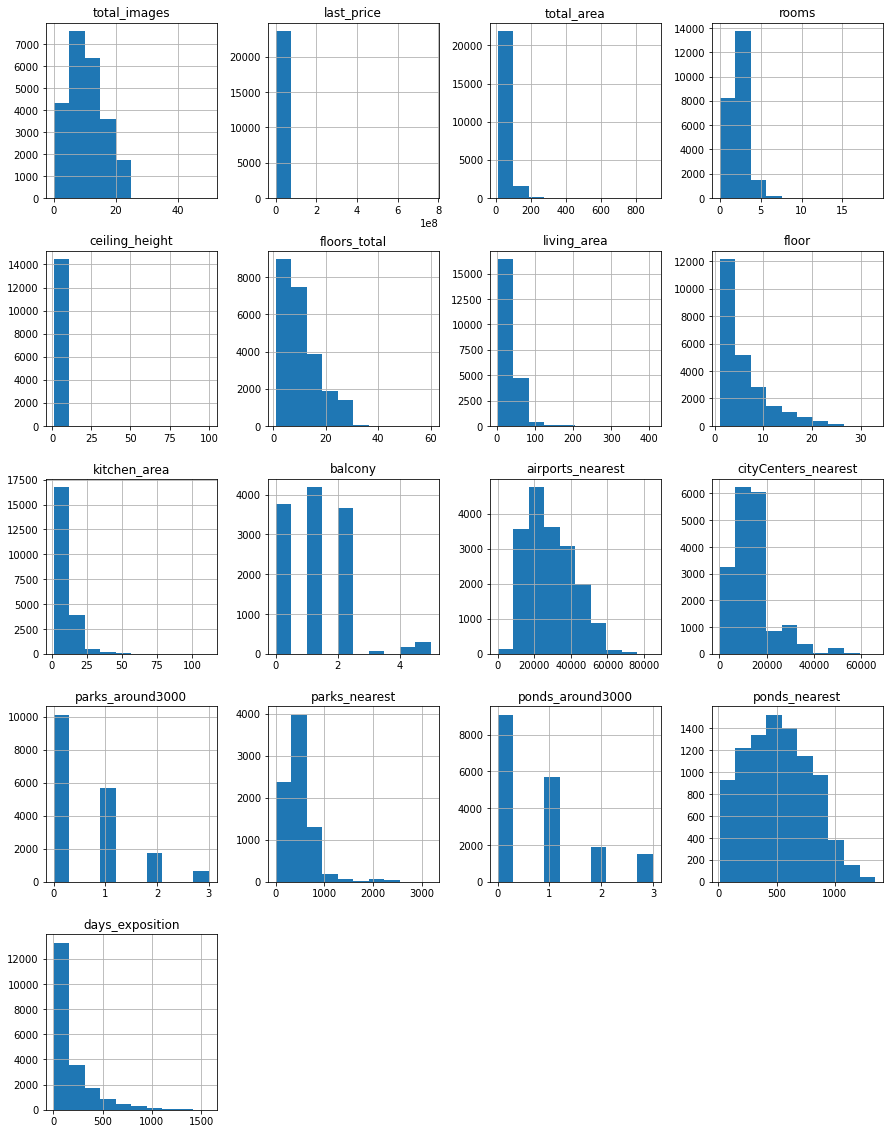

In [5]:
data.hist(figsize=(15, 20));

В результате изучения общей информации о датафрейме было выявлено, что:
- больше половины признаков содержат пропуски;
- в некоторых параметрах замечен неверный тип данных (например, в показателях о дате и сроках публикации объявлений в `first_day_exposition` и `days_exposition` соответственно);
- данные нуждаются в проверке на дубликаты и выбросы.

### Предобработка данных

#### Пропущенные значения

Ниже представлен перечень переменных, в которых содержатся пропущенные значения (NaN), и логичный способ восстановления полноты данных:
- `ceiling_height` - замена NaN на медиану,
- `living_area` - замена NaN по доле жилой площади в общей площади,
- `kitchen_area` - замена NaN по доле площади кухни в общей площади,
- `is_apartment` - замена NaN на значение 0 (предположение: объект недвижимости является квартирой), 
- `balcony` - замена NaN на значение 0 (предположение: в объекте недвижимости балкон отсутствует),
- `parks_around3000` - замена NaN на значение 0 (предположение: в радиусе 3 км от объекта недвижимости нет парков), 
- `ponds_around3000` - замена NaN на значение 0 (предположение: в радиусе 3 км от объекта недвижимости нет водоемов).

Для следующих переменных предложить качественный способ замены пропущенных значений (NaN) затруднительно. Среди таких полей фигурируют: 
- `floors_total`,
- `locality_name`,
- `airports_nearest`,
- `cityCenters_nearest`,
- `parks_nearest`,
- `ponds_nearest`,
- `days_exposition`.

In [6]:
# проанализируем описательную статистику переменной `ceiling_height`, чтобы убедиться в правильности выбора медианы для замены NaN
data['ceiling_height'].describe() # исследуем описательную статистику 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В переменной `ceiling_height` содержатся экстремально высокие и низкие значения. В данном случае наиболее типичным значением будет являться медианное. В целях заполнения пропущенных значений предпочтение отдаем медиане, а не среднему.

In [7]:
data['ceiling_height'] = data['ceiling_height'].where(~data['ceiling_height'].isna(), data['ceiling_height'].median())

count    21796.000000
mean         0.564766
std          0.105368
min          0.021583
25%          0.495177
50%          0.567860
75%          0.637880
max          1.000000
dtype: float64

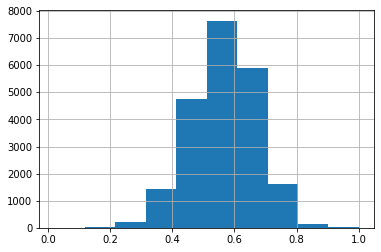

In [8]:
# проанализируем целесообразность замены NaN в переменной `living_area` с использованием доли жилой площади в общей площади 
(data['living_area'] / data['total_area']).hist() # построим гистограмму для этой величины
(data['living_area'] / data['total_area']).describe() # исследуем описательную статистику 

Доля жилой площади в общей площади рассматриваемой совокупности объектов недвижимости распределена нормально.
Её средняя величина, типичная для большинства квартир и аппартаментов в Санкт-Петербурге, составила 56 %.
Замену пропущенных значений в переменной `living_area` таким способом будем считать адекватной исследуемой выборке. 

In [9]:
living_area_share = (data['living_area'] / data['total_area']).mean() # запишем результат расчета доли в отдельную переменную
data['living_area'] = data['living_area'].where(~data['living_area'].isna(), data['total_area'] * living_area_share) # произведем замену NaN

count    21421.000000
mean         0.187355
std          0.072968
min          0.025381
25%          0.133333
50%          0.172414
75%          0.232416
max          0.787879
dtype: float64

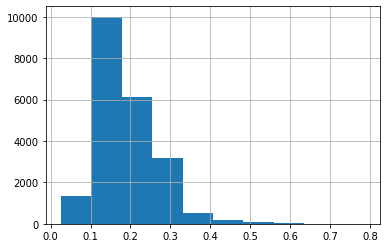

In [10]:
# аналогично проанализируем целесообразность замены NaN в переменной `kitchen_area` с использованием доли площади кухни в общей площади 
(data['kitchen_area'] / data['total_area']).hist() # построим гистограмму для этой величины
(data['kitchen_area'] / data['total_area']).describe() # исследуем описательную статистику 

In [11]:
kitchen_area_share = (data['kitchen_area'] / data['total_area']).mean() # запишем результат расчета доли в отдельную переменную
data['kitchen_area'] = data['kitchen_area'].where(~data['kitchen_area'].isna(), data['total_area'] * kitchen_area_share) # произведем замену NaN

In [12]:
# заменяем NaN на 0 в переменных
data['is_apartment'] = data['is_apartment'].where(~data['is_apartment'].isna(), 0) 
data['balcony'] = data['balcony'].where(~data['balcony'].isna(), 0)
data['parks_around3000'] = data['parks_around3000'].where(~data['parks_around3000'].isna(), 0)
data['ponds_around3000'] = data['ponds_around3000'].where(~data['ponds_around3000'].isna(), 0)

In [13]:
# вызовем метод info, чтобы убедиться в отсутствии пропусков в целевых переменных
data[[
    'ceiling_height',
    'living_area',
    'kitchen_area',
    'is_apartment',
    'balcony',
    'parks_around3000',
    'ponds_around3000'
]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ceiling_height    23699 non-null  float64
 1   living_area       23699 non-null  float64
 2   kitchen_area      23699 non-null  float64
 3   is_apartment      23699 non-null  object 
 4   balcony           23699 non-null  float64
 5   parks_around3000  23699 non-null  float64
 6   ponds_around3000  23699 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.3+ MB


Все пропущенные значения в обозначенных переменных датафрейма заменены.

#### Типы данных

Исходя из специфики параметров, содержащихся в датафрейме трансформируем тип object полей `first_day_exposition` и `is_apartment` в дату (datetime) и булеву переменную (bool) соответственно. Таким образом мы сможем оперировать данными с датой в первом случае и точно определять тип всех объектов недвижимости в нашем датафрейме. 

Количественные переменные `balcony`, `parks_around3000` и `ponds_around3000` представим целочисленными измерениями. 
Это преобразование необходимо для представления количества балконов, ближайших парков и водоемов в натуральных числах.     

Также логичными были бы замены типов переменных `days_exposition` и `floors_total`, но поскольку в них не удалось обработать пропущенные значения, оставим типы этих полей без изменений.    

In [14]:
# Замена типов переменных
# меняем формат object на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# меняем формат object на bool
data['is_apartment'] = data['is_apartment'].astype('bool')

# меняем формат float64 на int64
data['balcony'] = data['balcony'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)

#### Неявные дубликаты в названиях населённых пунктов 



In [15]:
# проанализируем какие значения содержит поле 'locality_name'
locality_name = pd.Series(data['locality_name'].unique()) # сохраним в объект Series уникальные значения 'locality_name'
pd.set_option('display.max_rows', None) # настроим вывод Series
locality_name.sort_values() # и выведем на экран

78                                          Бокситогорск
64                                              Волосово
29                                                Волхов
28                                            Всеволожск
16                                                Выборг
309                                               Высоцк
13                                               Гатчина
52                                           Зеленогорск
48                                             Ивангород
194                                         Каменногорск
30                                             Кингисепп
62                                                Кириши
18                                               Кировск
11                                               Колпино
10                                              Коммунар
40                                          Красное Село
17                                             Кронштадт
57                             

In [16]:
# добавим новое поле в датафрейм, в котором будут представлены преобразованные (очищенные) значения из поля 'locality_name'
# преобразуем названия населенных пунктов удалив их обозначения

data['clean_locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа ', 
              'городской поселок ',
              'коттеджный поселок ',
              'поселок станции ',
              'поселок при железнодорожной станции ',
              'поселок ', 
              'село ', 
              'деревня ', 
              'садоводческое некоммерческое товарищество ',
              'садовое товарищество '],
             '', regex=True)
)

In [17]:
# визуально оценим полученные результаты после преобразований поля 'locality_name'
clean_locality_name = pd.Series(data['clean_locality_name'].unique()) # сохраним в объект Series уникальные значения 'clean_locality_name'
clean_locality_name.sort_values() # и выведем на экран

89                   Агалатово
72             Александровская
224                 Алексеевка
33                      Аннино
128                        Аро
107                   Барышево
100                     Батово
115                   Бегуницы
95                   Белогорка
223                 Белоостров
71                Бокситогорск
246              Большая Вруда
87               Большая Ижора
266         Большая Пустомержа
98             Большие Колпаны
297            Большое Рейзино
294              Большой Сабск
244                        Бор
304             Борисова Грива
55                       Бугры
198                   Будогощь
280                   Ваганово
181                     Важины
84                   Вартемяги
268               Вахнова Кара
133                     Вещево
187                    Виллози
240                 Вознесенье
192                Возрождение
140                 Войсковицы
179                 Войскорово
301                Володарское
59      

In [18]:
# посчитаем количество уникальных значений до и после преобразований
print(f'Количество уникальных значений населенных пунктов до преобразований: {len(locality_name.unique())}') 
print(f'Количество уникальных значений населенных пунктов после преобразований: {len(clean_locality_name.unique())}') 

Количество уникальных значений населенных пунктов до преобразований: 365
Количество уникальных значений населенных пунктов после преобразований: 306


Способ, который был предложен для обработки неявных дубликатов в столбце `locality_name`, позволил получить новый показатель, очищенный от различных вариантов написания одних и тех же населенных пунктов, в котором содержится 306 уникальных наименований. 

#### Аномалии

В ходе предобработки данных были выявлены следующие показатели, в которых содержатся аномальные и выбивающиеся значения:
- `last_price`,
- `total_area`,
- `rooms`,  
- `ceiling_height`,
- `locality_name`. 

Показатели стоимости и общей площади `last_price` и `total_area` могут содержать слишком большие значения, которые не характерны для типовых объектов жилой недвижимости.

Объект недвижимости должен иметь хотя бы одну комнату, поэтому необходимо проверить содержит ли показатель `rooms` значение `0`.

Высота потолков `ceiling_height` должна соответствовать нормативным стандартам для массовых застроек. Резко отличающиеся величины можно считать отклонением от типичного наблюдения рассматриваемого набора данных.   

В ходе обработки неявных дубликатов в названиях населённых пунктов было замечено, что в списке уникальных наименований населённых пунктов содержится значение `NaN`. Поскольку значения в таких записях не подлежат восстановлению - их необходимо удалить.

Ниже проанализируем наличие аномалий отдельно по каждому из названных показателей. Затем удалим эти аномалии из датафрейма и оценим полученный результат.

#####  Анализ аномалий по цене на момент снятия с публикации `last_price`

In [19]:
pd.set_option('display.float_format', '{:.2f}'.format) # установим формат отображения нецелочисленных значений
data['last_price'].describe()

count       23699.00
mean      6541548.77
std      10887013.27
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
max     763000000.00
Name: last_price, dtype: float64

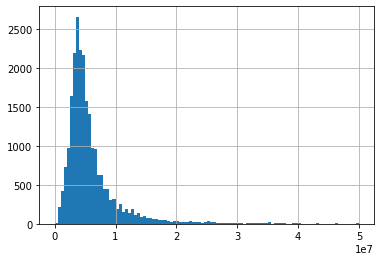

In [20]:
data['last_price'].hist(bins=100,range=(0,50000000));

На гистограмме видно, что множество значений `last_price` лежит справа от третьего квартиля, а максимальное значение 763 млн почти в полторы сотни раз превосходит медиану. Данное распределение напоминает распределение Пуассона.

В целях устранения слишком сильно выбивающихся значений и получения более однородной совокупности можно отсечь выбросы, лежащие выше верхней границы, в качестве которой возьмем значение 30 млн. 

In [21]:
print(f"Количество аномальных и выбивающихся наблюдений по полю `last_price`: \
{len(data.query('last_price > 30000000'))}")
print(f"Доля аномальных и выбивающихся наблюдений по полю `last_price` от общего объема датафрейма: \
{round((len(data.query('last_price > 30000000')) / len(data['last_price']) * 100), 2)} %")

Количество аномальных и выбивающихся наблюдений по полю `last_price`: 316
Доля аномальных и выбивающихся наблюдений по полю `last_price` от общего объема датафрейма: 1.33 %


#####  Анализ аномалий по общей площади `total_area`

In [22]:
# проанализируем данный показатель аналогично `last_price`
pd.set_option('display.float_format', '{:.2f}'.format)
data['total_area'].describe()

count   23699.00
mean       60.35
std        35.65
min        12.00
25%        40.00
50%        52.00
75%        69.90
max       900.00
Name: total_area, dtype: float64

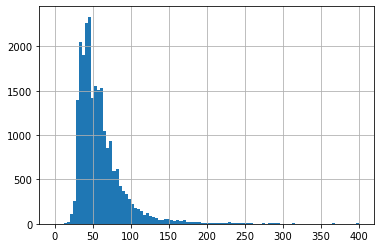

In [23]:
data['total_area'].hist(bins=100, range=(0,400));

Заметим, что в выборке также присутствует большое количество выбросов. Найдем их количество тем же способом, который был использован для `last_price`. В качестве значения 

In [24]:
print(f"Количество аномальных и выбивающихся наблюдений по полю `total_area`: \
{len(data.query('total_area > 200'))}")
print(f"Доля аномальных и выбивающихся наблюдений по полю `total_area` от общего объема датафрейма: \
{round((len(data.query('total_area > 200')) / len(data['total_area']) * 100), 2)} %")

Количество аномальных и выбивающихся наблюдений по полю `total_area`: 227
Доля аномальных и выбивающихся наблюдений по полю `total_area` от общего объема датафрейма: 0.96 %


#####  Анализ аномалий по числу комнат `rooms`

In [25]:
data['rooms'].unique() # выведем на экран уникальные значения `rooms` 

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

В датафрейме присутствует нулевое значение в столбце `rooms`.

In [26]:
print(f"Количество аномальных и выбивающихся наблюдений по полю `rooms`: \
{len(data.query('rooms == 0'))}")
print(f"Доля аномальных и выбивающихся наблюдений по полю `total_area` от общего объема датафрейма: \
{round(((len(data.query('rooms == 0')) / len(data['rooms'])) * 100), 2)} %")

Количество аномальных и выбивающихся наблюдений по полю `rooms`: 197
Доля аномальных и выбивающихся наблюдений по полю `total_area` от общего объема датафрейма: 0.83 %


#####  Анализ аномалий по высоте потолков `ceiling_height`

count   23699.00
mean        2.72
std         0.99
min         1.00
25%         2.60
50%         2.65
75%         2.70
max       100.00
Name: ceiling_height, dtype: float64

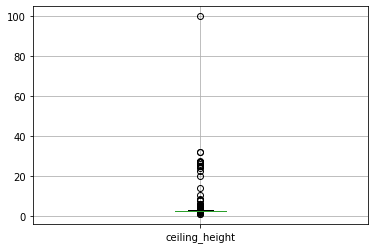

In [27]:
pd.set_option('display.float_format', '{:.2f}'.format)
data.boxplot('ceiling_height');
data['ceiling_height'].describe()

Наблюдаем множество выбросов. 

Примем значения выше 20 метров как ошибку в данных, возникшую в результате неправильного ввода числовых данных в систему. Преобразуем эти значения так, чтобы они не отличались от основной массы.

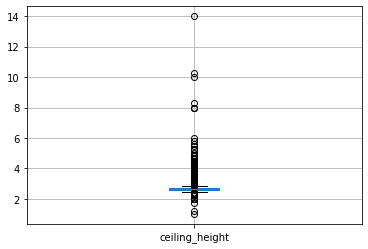

In [28]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] /= 10 # разделим на 10 обозначенные значения
data.boxplot('ceiling_height'); # еще раз выведем диаграмму размаха

Сейчас распределение данных выглядит более правдоподобно. Однако аномально высоких и крайне низких значений высоты потолка в объектах жилой недвижимости осталось очень много.

В данном случае способ, при котором мы отсекали значения на основе квартильных величин не подходит, поскольку существуют государственные стандарты, в которых указана минимальная высота потолков в жилых помещениях - от 2,5 метров.
Для верхней границы возьмем значение, равное 4 метрам, которое могло встречаться в жилых объектах старой застройки. Жилье, в котором уровень потолков выше этого значения будем считать застройкой по индивидуальному проекту, то есть нетиповым жильем, и исключим из выборки.  

In [29]:
print(f"Количество аномальных и выбивающихся наблюдений по полю `ceiling_height`: \
{len(data.query('ceiling_height < 2.5 or ceiling_height >= 4'))}")
print(f"Доля аномальных и выбивающихся наблюдений по полю `ceiling_height` от общего объема датафрейма: \
{round(((len(data.query('ceiling_height < 2.5 or ceiling_height >= 4')) / len(data['ceiling_height'])) * 100), 2)} %")

Количество аномальных и выбивающихся наблюдений по полю `ceiling_height`: 168
Доля аномальных и выбивающихся наблюдений по полю `ceiling_height` от общего объема датафрейма: 0.71 %


#####  Анализ аномалий (пропущенных значений) по названию населённых пунктов `clean_locality_name`

In [30]:
# выведем на экран информацию о пропущенных значениях в столбце `clean_locality_name`
print(f"Количество аномальных и выбивающихся наблюдений по полю `clean_locality_name`: \
{len(data.query('clean_locality_name.isna()'))}")
print(f"Доля аномальных и выбивающихся наблюдений по полю `clean_locality_name` от общего объема датафрейма: \
{round(((len(data.query('clean_locality_name.isna()')) / len(data['clean_locality_name'])) * 100), 2)} %")

Количество аномальных и выбивающихся наблюдений по полю `clean_locality_name`: 49
Доля аномальных и выбивающихся наблюдений по полю `clean_locality_name` от общего объема датафрейма: 0.21 %


##### Формирование нового датафрейма без аномалий

In [31]:
# запишем в новый датафрейм записи из изначального, которые удовлетворяют всем критериям
good_data = data.query('last_price < 30000000 and \
                       total_area < 200 and \
                       rooms != 0 and \
                       ceiling_height.round(1) >= 2.5 and \
                       ceiling_height.round(1) < 4 and \
                       clean_locality_name.notna()').reset_index(drop=True)


In [32]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22896 entries, 0 to 22895
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22896 non-null  int64         
 1   last_price            22896 non-null  float64       
 2   total_area            22896 non-null  float64       
 3   first_day_exposition  22896 non-null  datetime64[ns]
 4   rooms                 22896 non-null  int64         
 5   ceiling_height        22896 non-null  float64       
 6   floors_total          22815 non-null  float64       
 7   living_area           22896 non-null  float64       
 8   floor                 22896 non-null  int64         
 9   is_apartment          22896 non-null  bool          
 10  studio                22896 non-null  bool          
 11  open_plan             22896 non-null  bool          
 12  kitchen_area          22896 non-null  float64       
 13  balcony         

In [33]:
print(f'Всего из датафрейма было удалено {round((100 - ((len(good_data) / len(data)) * 100)),(2))} % данных')

Всего из датафрейма было удалено 3.39 % данных


### Посчитайте и добавьте в таблицу новые столбцы

Добавляем в датафрейм с очищенными данными новые столбцы со следующими параметрами:
- цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [34]:
good_data['sqm_price'] = (good_data['last_price'] / good_data['total_area']).round(2) # расчет цены одного квадратного метра

In [35]:
good_data['weekday_exposition'] = good_data['first_day_exposition'].dt.weekday # добавляем день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)

In [36]:
good_data['month_exposition'] = good_data['first_day_exposition'].dt.month # добавляем месяц публикации объявления

In [37]:
good_data['year_exposition'] = good_data['first_day_exposition'].dt.year # добавляем год публикации объявления

In [38]:
# добавляем переменную с типом этажа квартиры (значения — «первый», «последний», «другой»)

# пишем функцию для одной строки
def categorize_floor(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floors_total == floor and floors_total != 1:
        return 'последний'
    else:
        return 'другой'

In [39]:
good_data['floor_type'] = good_data.apply(categorize_floor, axis=1) # применяем функцию к соответствующему столбцу в датафрейме

In [40]:
# находим расстояние до центра города в километрах (переведим из м в км и округлим до ближайших целых значений)
good_data['cityCenters_nearest_km'] = (good_data['cityCenters_nearest'] / 1000).round(2)

### Проведите исследовательский анализ данных

#### Изучите параметры объектов и постройте отдельные гистограммы для каждого из этих параметров.

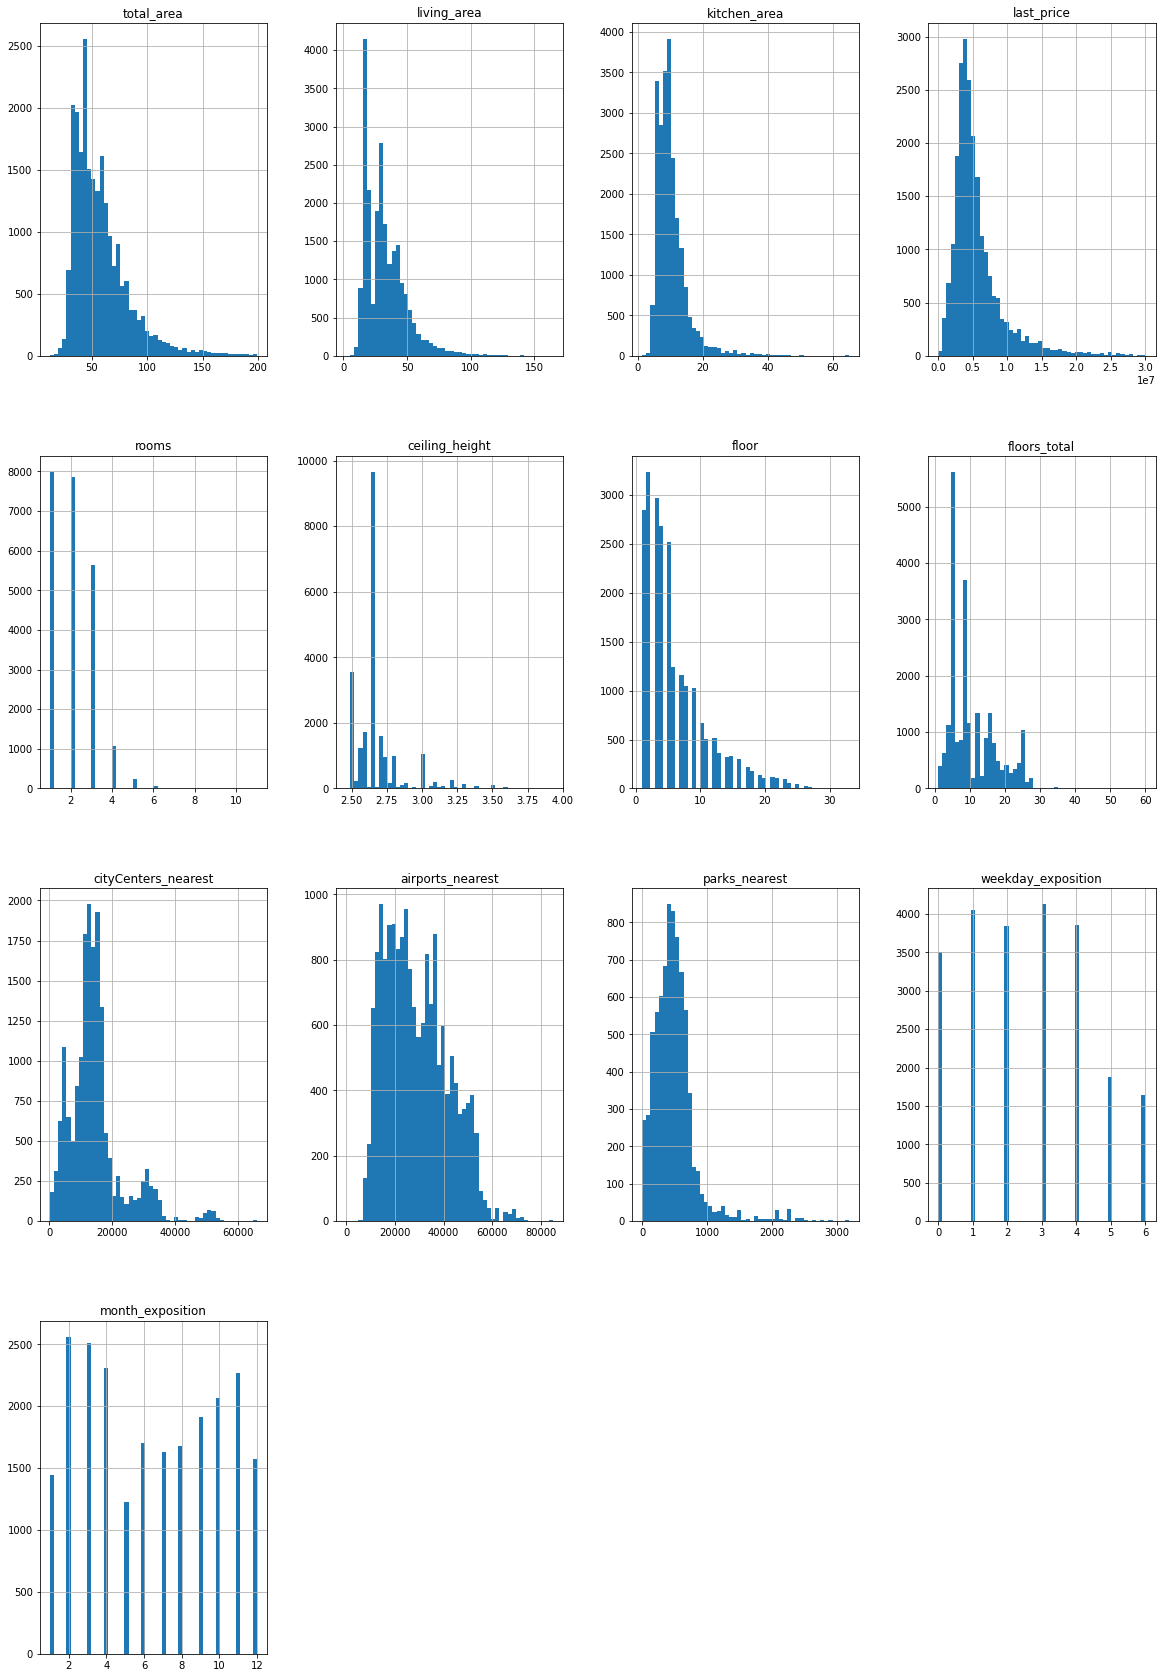

In [41]:
good_data.hist(['total_area',
                'living_area',
                'kitchen_area',
                'last_price',
                'rooms',
                'ceiling_height',
                'floor',
                'floor_type',
                'floors_total',
                'cityCenters_nearest',
                'airports_nearest',
                'parks_nearest',
                'weekday_exposition',
                'month_exposition'
               ], bins=50, figsize=(20, 30));

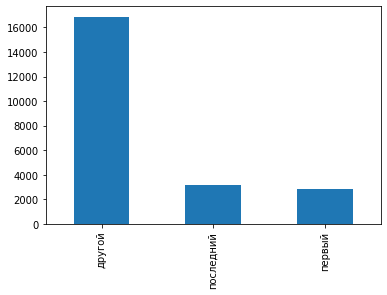

In [42]:
good_data['floor_type'].value_counts().plot(kind='bar'); # для строковых данных переменной 'floor_type' выведем отдельно гистограмму

По итогам анализа целевых параметров было установлено, что:
1. `total_area` - Выделяются два основных пика общей площади - около 30 кв.м и 45 кв.м.
2. `living_area` - По жилой площади прослеживаются более ярко выраженные и однородные пики, чем по общей площади - первый - чуть менее 20 кв.м, второй - около 30 кв.м.
3. `kitchen_area` - Кухонное пространство обычно занимает от 5 кв.м. до 10 кв.м.
4. `last_price` - В среднем все объекты недвижимости в выборке стоят 4 млн, распределение цены напоминает нормальное при отброшенном правом хвосте.
5. `rooms` - Популярны однокомнатные и двухкомнатные квартиры. Каждая четвертая квартира в рассматриваемых данных - трехкомнатная. Другие варианты комнатности слабо распространены. 
6. `ceiling_height` - Абсолютное большинство объектов в выборке имеет высоту потолков около 2,6 метров
7. `floor` - Самыми ходовыми можно считать квартиры и аппартаменты, расположенные на втором этаже. Поскольку большинство домов имеют по 5 и 9 этажей, то самые популярные предложения лежат в пределах до 9 этажа.
8. `floor_type` - Типичная квартира или аппартаменты, выставленные на продажу, расположены не на первом и не на последнем этажах. 
9. `floors_total` - Наиболее часто встречаются пятиэтажные и девятиэтажные строения.
10. `cityCenters_nearest` - Объекты недвижимости в основном располагаются на периферии - городские центры для большинства квартир находятся на расстоянии от 10 км до 20 км.
11. `airports_nearest` - Ближайшие аэропорты удалены от основного жилого массива в городских и сельских поселениях на 15 км и дальше.
12. `parks_nearest` - Ближайшие парки расположены на расстоянии не более километра, для большинства объектов парковые зоны находятся в пределах 500 метров от дома.
13. `weekday_exposition` - Чаще объявления о продаже квартир и аппартаментов размещались в будние дни кроме понедельника. В выходные дни интенсивность публикации объявлений падает в два раза, по сравнению с буднями.
14. `month_exposition` - На размещение объявлений влияет сезонность: с февраля по апрель, а также с сентября по ноябрь люди чаще, чем под конец года и во время летних отпусков, решаются на продажу жилья.

#### Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.


Этот параметр показывает, сколько дней «висело» каждое объявление.
-	Постройте гистограмму.
-	Посчитайте среднее и медиану.
-	В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"


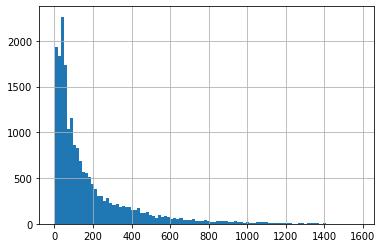

In [43]:
good_data['days_exposition'].hist(bins=100); # строим гистограмму для `days_exposition`

In [44]:
good_data['days_exposition'].mean().round(1) # рассчитаем среднее значение

179.3

In [45]:
good_data['days_exposition'].median() # выведем на экран медиану

95.0

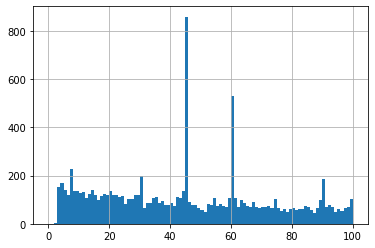

In [46]:
good_data['days_exposition'].hist(bins=100,range=(0,100));

Медиана показателя `days_exposition` существенно отличается от среднего значения.

Распределение количества дней размещения объявлений на сайте в нашей выборке напоминает распределение Пуассона.
В качестве типичной характеристики такого распределения будем считать медиану.

В среднем продажа квартиры или аппартаментов обычно занимает около 3 месяцев.
Тогда логично предположить, что слишком быстрыми продажами можно считать сделки, совершенные примерно в течение 14 дней, а необычно долгими - операции, проводимые через два года после публикации объявления. 

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.
- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год);


In [47]:
# сформируем датафрейм для анализа факторов, влияющих на стоимость объекта
good_data_corr = good_data[['last_price',
                            'total_area',
                            'living_area',
                            'kitchen_area',
                            'rooms',
                            'floor_type',
                            'weekday_exposition',
                            'month_exposition',
                            'year_exposition']]

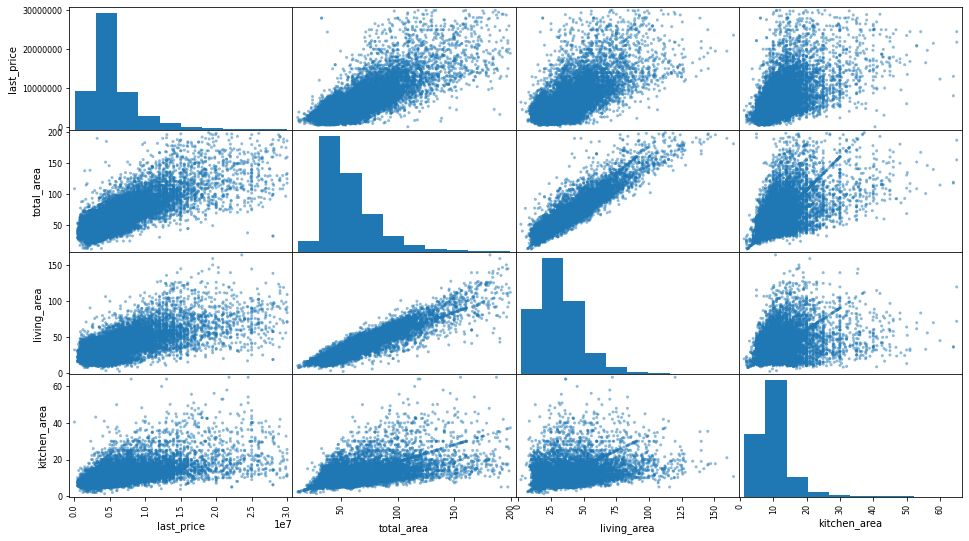

In [48]:
# построим графики отдельно для числовых (интервальных) данных
pd.plotting.scatter_matrix(good_data_corr[['last_price', 'total_area', 'living_area', 'kitchen_area']], figsize=(16, 9)); 

Характер взаимосвязи цены и показателей площади примерно одинаковый - она прямая, однако объекты с более высокой ценой имеют больший разброс площади, а объекты с низкой ценой - более однородны по площадям.

Далее отдельно построим графики для порядковых данных и строковых переменных. Для этого сгруппируем данные по ценам на объекты недвижимости. В качестве группирующей функции возьмем медиану.

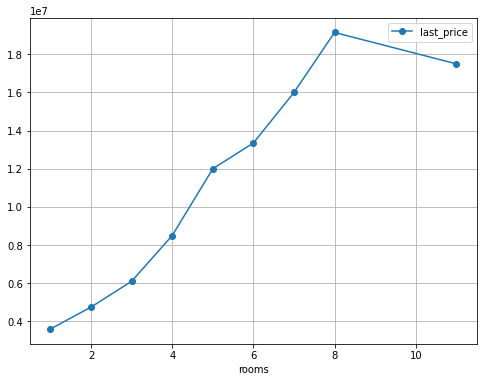

In [49]:
# строим график зависимости цены от числа комнат в объекте
(good_data_corr
 .pivot_table(index='rooms', values='last_price', aggfunc='median')
 .plot(figsize=(8, 6), style='-o', sharex=False, grid=True)
);

Прослеживается прямая зависимость - чем больше комнат, тем выше стоимость объекта.

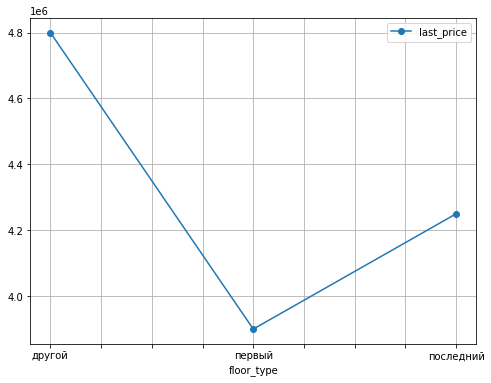

In [50]:
# строим график зависимости цены от типа этажа, на котором расположен объект
(good_data_corr
 .pivot_table(index='floor_type', values='last_price', aggfunc='median')
 .plot(figsize=(8, 6), style='-o', sharex=False, grid=True)
);

Объекты на первом этаже - самые дешевые. На последнем этаже цена объектов также невысока, как на первом этаже, но она гораздо меньше, чем у объектов на других этажах.

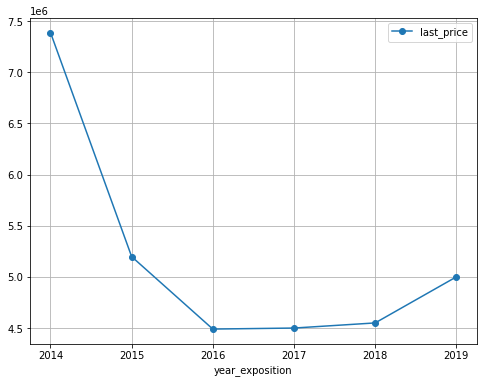

In [51]:
# строим график зависимости цены от года размещения объявления о продаже объекта
(good_data_corr
 .pivot_table(index='year_exposition', values='last_price', aggfunc='median')
 .plot(figsize=(8, 6), style='-o', sharex=False, grid=True)
);

Прямой зависимости между годом публикации объявления и ценой объекта не наблюдается.
В нашей выборке присутствуют объекты, которые были размещены в 2014 году. Если в последние годы цена незначительно росла, но в целом оставалась примерно на одном уровне, то более "старые" объявления, по всей видимости, касаются очень дорогих объектов, которые за весь период так и не удалось реализовать. Отсюда столь высокие значения медианы цены.

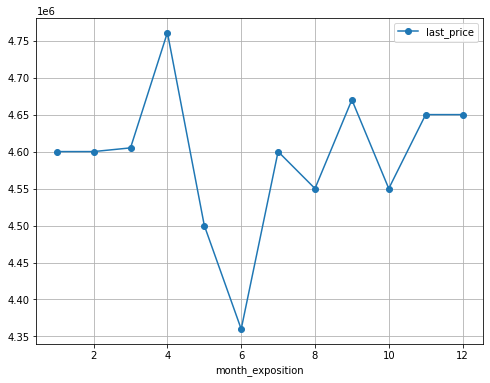

In [52]:
# строим график зависимости цены от месяца размещения объявления о продаже объекта
(good_data_corr
 .pivot_table(index='month_exposition', values='last_price', aggfunc='median')
 .plot(figsize=(8, 6), style='-o', sharex=False, grid=True)
);

Сильную неоднородность по цене имеют объекты, объявления по которым были размещены весной, летом или осенью. У объявлений, размещенных в зимние месяцы цены стабильные.

На графике видно, что ни положительной, ни отрицательной зависимости цены от месяца публикации объявления нет - цена, хоть и с большими колебаниями, варьируется около типичного уровня.

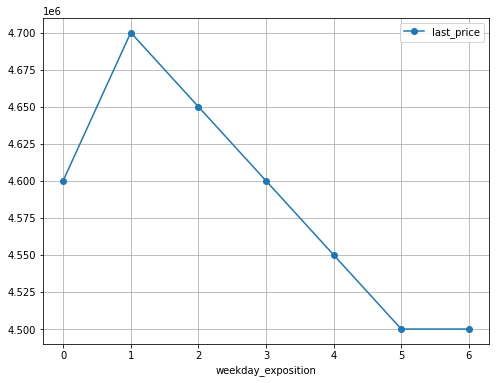

In [53]:
# строим график зависимости цены от дня недели размещения объявления о продаже объекта
(good_data_corr
 .pivot_table(index='weekday_exposition', values='last_price', aggfunc='median')
 .plot(figsize=(8, 6), style='-o', sharex=False, grid=True)
);

Поразительно, но цена объектов, объявления по которым размещены на сайте, обратно зависит от дня недели публикации. В будни медиана цены реализуемого жилья выше, чем в выходные. Но общее колебание цен в течение всех дней недели лежит в интервале от 4,5 млн до 4,7 млн, варьируясь около 4,6 млн.

Для того, чтобы точнее оценить влияние рассматриваемых факторов на цену объектов, построим матрицу коэффициентов корреляции, которые служат числовой мерой тесноты взаимосвязи параметров.

In [54]:
# преобразуем строковые значения столбца 'floor_type' в числовые
good_data_corr['floor_type_int'] = good_data_corr['floor_type'].replace(['первый', 'другой', 'последний'], [0, 1, 2])

/tmp/ipykernel_267/2972725891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data_corr['floor_type_int'] = good_data_corr['floor_type'].replace(['первый', 'другой', 'последний'], [0, 1, 2])


In [55]:
good_data_corr[['last_price',
                'total_area',
                'living_area',
                'kitchen_area',
                'rooms',
                'floor_type']].corr() # построим матрицу парных коэффициентов корреляции Пирсона

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.00,0.79,0.68,0.61,0.49
total_area,0.79,1.00,0.93,0.59,0.79
living_area,0.68,0.93,1.00,0.37,0.87
kitchen_area,0.61,0.59,0.37,1.00,0.23
rooms,0.49,0.79,0.87,0.23,1.00


Самая сильная взаимосвязь прослеживается между ценой и общей площадью объекта. 
Поскольку жилая площадь и площадь кухни зависият от величины общей площади, они столь же тесно взаимосвязаны с ценой объекта.

Наконец, существенное влияние на цену оказывает число комнат в объекте недвижимости. Этот параметр также сильно взаимосвязан с общей и жилой площадью, поэтому проявляет себя как значимый фактор цены жилья.

Коэффициенты корреляции демонстрируют отсутствие взаимосвязи между ценой жилья и этажностью и датой размещения объявлений. 

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [56]:
# построим сводную таблицу с количеством объявлений и средней ценой квадратного метра 
pivot_data_locality = (good_data
 .pivot_table(index='clean_locality_name', values='sqm_price', aggfunc=['count', 'median']))

In [57]:
pivot_data_locality.columns = ['count', 'sqm_price'] # переименуем столбцы сводной таблицы

In [58]:
# из полученной сводной таблицы сформируем отсортированный по количеству объявлений датафрейм с топ-10 населённых пунктов с наибольшим числом объявлений
top10_locality = (pivot_data_locality
                  .sort_values(by='count', ascending=False)
                  .head(10))

In [59]:
top10_locality # выведем датафрейм на экран

,count,sqm_price
clean_locality_name,,
Санкт-Петербург,15123,104029.06
Мурино,562,84801.38
Кудрово,450,95435.61
Шушары,435,76666.67
Всеволожск,389,65789.47
Пушкин,358,99725.49
Колпино,336,74723.74
Парголово,321,92051.28
Гатчина,306,67860.57


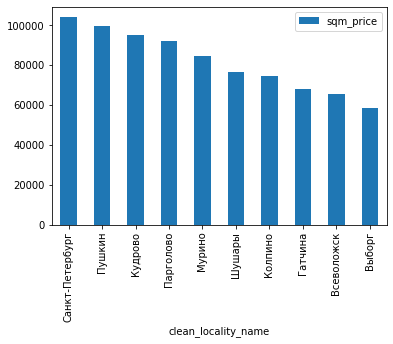

In [60]:
# отсортируем населённые пункты с самой высокой и низкой стоимостью квадратного метра.
(top10_locality
 .sort_values(by='sqm_price', ascending=False)
 .plot(y='sqm_price', kind='bar'));

Результаты не противоречат логике. В крупных населенных пунктах Ленинградской области, пригородах и сателлитах Санкт-Петербурга - самый большой объем предложений жилья. Из этих населенных пунктов средняя самая высокая стоимость одного квадратного метра в Петербурге, самая низкая - в Выборге. 

#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города — постройте график изменения средней цены для каждого километра от центра Петербурга.

In [61]:
# сформируем отдельный датафрейм с данными по Санкт-Петербургу
good_data_spb = good_data.query('locality_name == "Санкт-Петербург"')

<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='sqm_price'>

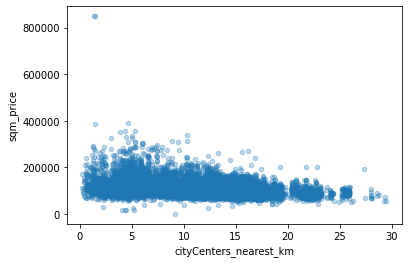

In [62]:
# построим график изменения средней цены для каждого километра от центра Петербурга
good_data_spb.plot(x='cityCenters_nearest_km', y= 'sqm_price', kind='scatter', alpha=0.3)

Общий вывод по графику: чем ближе к центру - тем выше цена на жилье. 

На расстоянии от центра Петербурга примерно до 10 км отчетливо видно насколько неоднородно предложение жилья на рынке - объявления о продаже включают как вполне бюджетные объекты, так и элитное жилье. 

Дальше от центра - на расстоянии от 10 до 20 км - объекты более однородны по цене за квадратный метр. 

Наконец, в совсем удаленных от центра районах объявлений о продаже квартир и аппартаментов мало в нашей выборке. По стоимости квадратного метра площади эти объекты существенно не отличаются друг от друга, по сравнению с предложениями из центральных районов Петербурга. 

### Общий вывод

В ходе исследования мы обработали и проанализировали данные сервиса Яндекс.Недвижимость, которые содержат архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

Аномалии в данных в большей мере связаны с человеческим фактором. Скорее всего, ошибки произошли по причине неправильно ввода пользователями информации на сайт. На этапе предобработки удалось устранить редкие и выбивающиеся значения, а также восстановить часть данных. Недостатком автоматически формируемых данных является то, что они были присвоены не всем объектам недвижимости, что ограничивает возможности исследования.

В результате анализа параметров объектов недвижимости мы установили, что значимыми факторами, определяющими стоимость жилья являются: 
- общая площадь,
- жилая площадь,
- площадь кухни,
- число комнат,
- удаленность от центра города.

Этот вывод подтверждают построенные графики зависимости параметров и рассчитанные коэффициенты корреляции между признаками. Влияние остальных параметров несущественно, либо требует отдельного, более глубокого исследования.